# Analysis of AdaTempScal on LeNet5 for CIFAR10

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [21]:
import os
import sys
import time
sys.path.extend(['..'])

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import torch

%aimport models
from models import AdaptiveTempScaling, TempScaling
%aimport utils
from utils import compare_results, calib_split

In [4]:
%matplotlib inline

In [5]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')

## Load data and precomputed logits

In [6]:
CIFAR10_PATH = '../../data/CIFAR10'
MODEL_PATH = '../../trained_models/CIFAR10/lenet5'

In [7]:
X_train = np.load(os.path.join(CIFAR10_PATH, 'train_imas.npy'))
y_train = np.load(os.path.join(CIFAR10_PATH, 'train_labels.npy'))

X_val = np.load(os.path.join(CIFAR10_PATH, 'val_imas.npy'))
y_val = np.load(os.path.join(CIFAR10_PATH, 'val_labels.npy'))

X_test = np.load(os.path.join(CIFAR10_PATH, 'test_imas.npy'))
y_test = np.load(os.path.join(CIFAR10_PATH, 'test_labels.npy'))

In [8]:
Z_train = np.load(os.path.join(MODEL_PATH, 'train_logits.npy'))
Z_val = np.load(os.path.join(MODEL_PATH, 'val_logits.npy'))
Z_test = np.load(os.path.join(MODEL_PATH, 'test_logits.npy'))

### Calibrate models

In [9]:
N, dim = Z_train.shape

### Temp-Scal as baseline:
tempScaler = TempScaling()
tempScaler.fit(Z_val, y_val, v=True);

In [15]:
aTempScaler = AdaptiveTempScaling(dim)
aTempScaler.fit(Z_val, y_val, v=True, lr=1e-1, epochs=10000);

Finding optimum Temperature
On epoch: 134, NLL: 1.191e+04, Temp: 1.079, at time: 2.48s

Adapting Weight vector
On epoch: 9994, loss: 1.191e+04, at time: 196.23s



In [16]:
print('##### Results on train set:')
compare_results(predictions={'Uncal': softmax(Z_train, axis=1),
                             'TempScal': tempScaler.predictive(Z_train),
                             'AdaptiveTempScal': aTempScaler.predictive(Z_train)}, target=y_train, from_logits=False);

##### Results on train set:
  Calibrator      Accuracy           ECE   Brier Score           NLL
       Uncal         62.04          1.79     5.032e-01     4.255e+04
    TempScal         62.04          4.13     5.052e-01     4.281e+04
AdaptiveTempScal         62.04          4.16     5.052e-01     4.281e+04


In [17]:
print('##### Results on validation set:')
compare_results(predictions={'Uncal': softmax(Z_val, axis=1),
                             'TempScal': tempScaler.predictive(Z_val),
                             'AdaptiveTempScal': aTempScaler.predictive(Z_val)}, target=y_val, M=15, from_logits=False);

##### Results on validation set:
  Calibrator      Accuracy           ECE   Brier Score           NLL
       Uncal         57.34          2.75     5.535e-01     1.194e+04
    TempScal         57.34          1.34     5.526e-01     1.191e+04
AdaptiveTempScal         57.34          1.42     5.525e-01     1.191e+04


In [18]:
print('##### Results on test set:')
compare_results(predictions={'Uncal': softmax(Z_test, axis=1),
                             'TempScal': tempScaler.predictive(Z_test),
                             'AdaptiveTempScal': aTempScaler.predictive(Z_test)}, target=y_test, M=15, from_logits=False);

##### Results on test set:
  Calibrator      Accuracy           ECE   Brier Score           NLL
       Uncal         58.10          4.94     5.437e-01     1.165e+03
    TempScal         58.10          3.51     5.434e-01     1.164e+03
AdaptiveTempScal         58.10          3.45     5.433e-01     1.163e+03


### Temperature distribution

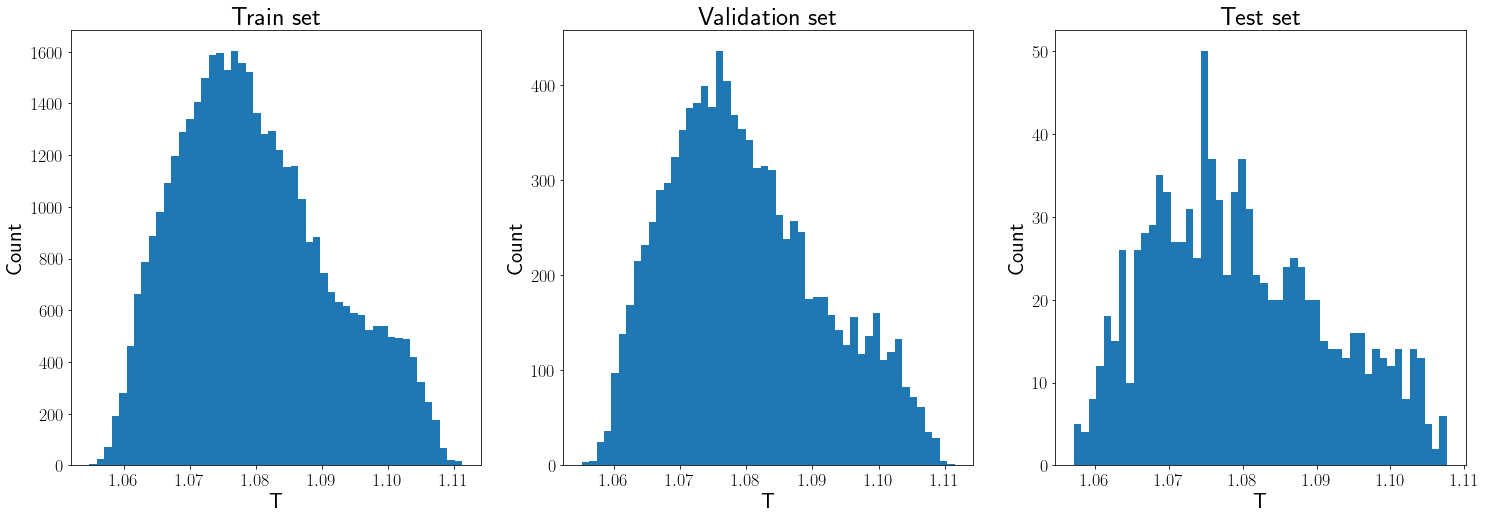

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(25, 8))

Ts = aTempScaler.get_T(Z_train)
ax[0].hist(Ts, bins=50)
ax[0].set_xlabel('T', fontsize=22)
ax[0].set_ylabel('Count', fontsize=22)
ax[0].set_title('Train set', fontsize=26)

Ts = aTempScaler.get_T(Z_val)
ax[1].hist(Ts, bins=50)
ax[1].set_xlabel('T', fontsize=22)
ax[1].set_ylabel('Count', fontsize=22)
ax[1].set_title('Validation set', fontsize=26)

Ts = aTempScaler.get_T(Z_test)
ax[2].hist(Ts, bins=50)
ax[2].set_xlabel('T', fontsize=22)
ax[2].set_ylabel('Count', fontsize=22)
ax[2].set_title('Test set', fontsize=26)

for _ax in ax.flatten():
    _ax.tick_params(axis='both', labelsize=18)
    

plt.show()

### Selected temperature for different confidences in test set

In [22]:
hc, lc, hi, li = calib_split(Z_test, y_test)

ts_aux = TempScaling()
ts_aux.fit(Z_test[hc | hi], y_test[hc | hi]);
T_hc = ts_aux.T.detach().numpy()

ts_aux = TempScaling()
ts_aux.fit(Z_test[lc | li], y_test[lc | li]);
T_lc = ts_aux.T.detach().numpy()


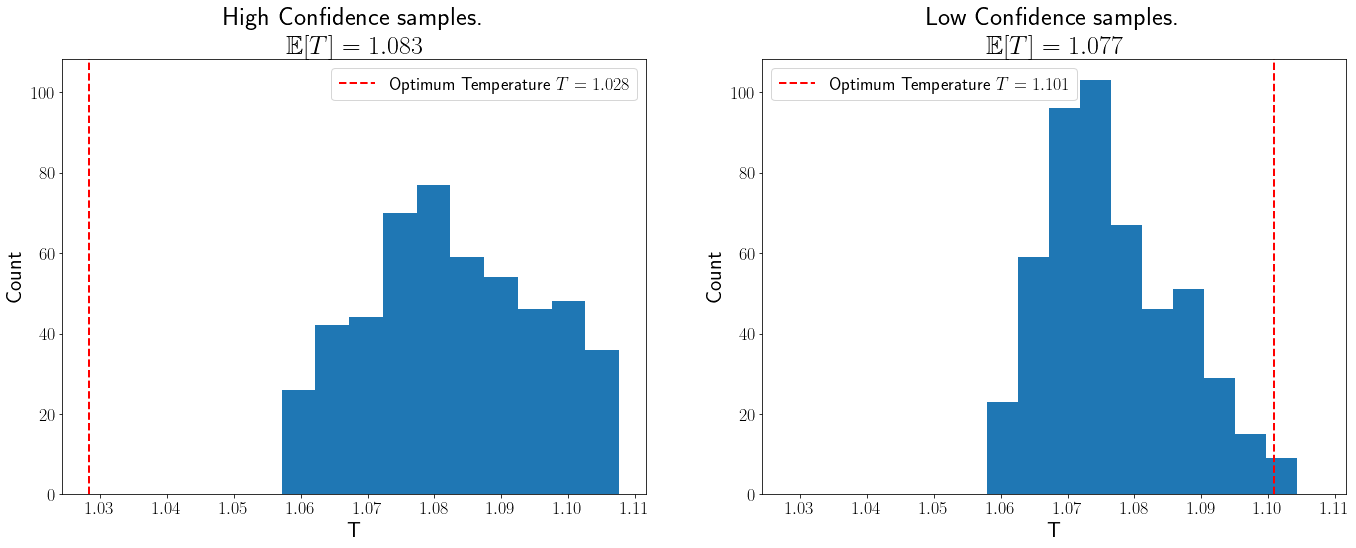

In [25]:
Ts = aTempScaler.get_T(Z_test)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(23, 8))


ax[0].hist(Ts[hc | hi])
ax[0].axvline(T_hc, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_hc[0]))
ax[0].set_title('High Confidence samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[hc | hi])), fontsize=26)
ax[0].legend(fontsize=18)



ax[1].hist(Ts[lc | li])
ax[1].axvline(T_lc, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_lc[0]))
ax[1].set_title('Low Confidence samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[lc | li])), fontsize=26)
ax[1].legend(fontsize=18)

for _ax in ax.flatten():
    _ax.yaxis.set_tick_params(labelleft=True)
    _ax.set_xlabel('T', fontsize=22)
    _ax.set_ylabel('Count', fontsize=22)
    _ax.tick_params(axis='both', labelsize=18)
plt.show();

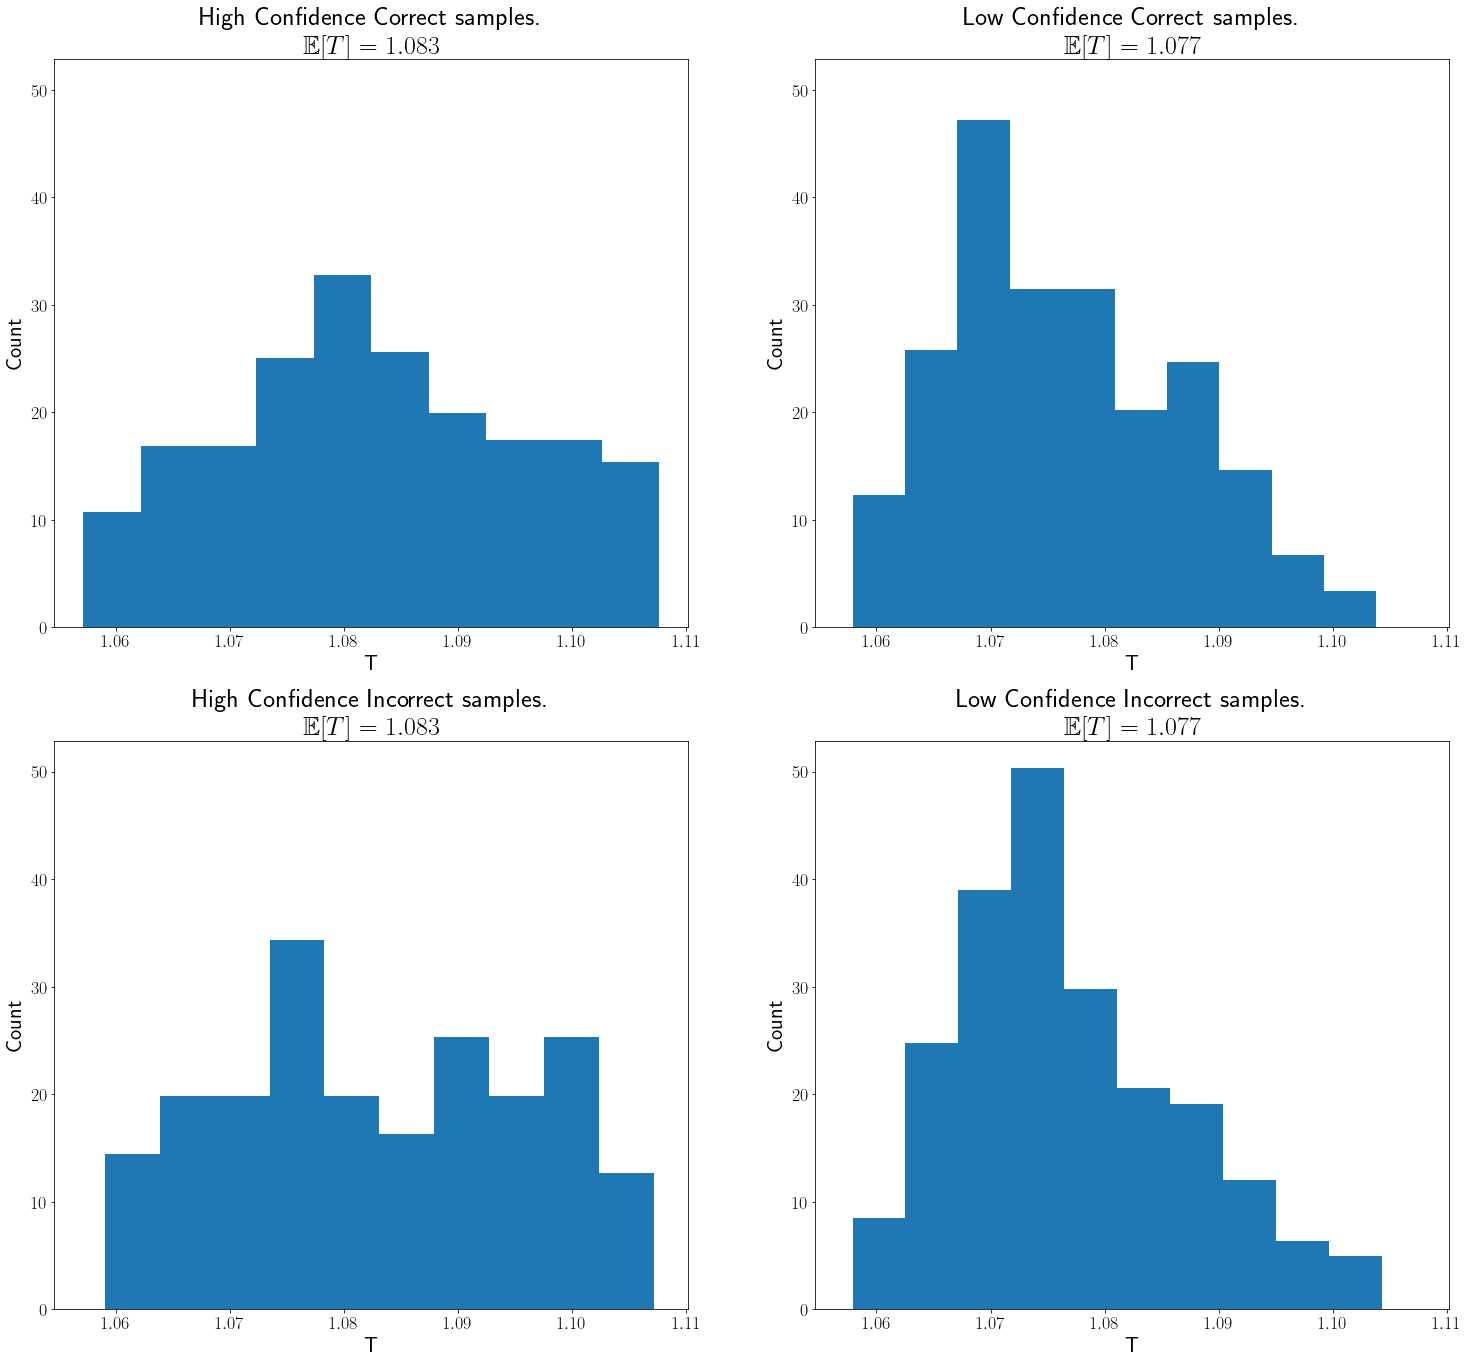

In [45]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(25, 23))


ax[0, 0].hist(Ts[hc], density=True)
ax[0, 0].set_title('High Confidence Correct samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[hc])), fontsize=26)

ax[0, 1].hist(Ts[lc], density=True)
ax[0, 1].set_title('Low Confidence Correct samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[lc])), fontsize=26)


ax[1, 0].hist(Ts[hi], density=True)
ax[1, 0].set_title('High Confidence Incorrect samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[hi])), fontsize=26)

ax[1, 1].hist(Ts[li], density=True)
ax[1, 1].set_title('Low Confidence Incorrect samples.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[li])), fontsize=26)

for _ax in ax.flatten():
    _ax.yaxis.set_tick_params(labelleft=True)
    _ax.xaxis.set_tick_params(labelbottom=True)
    _ax.set_xlabel('T', fontsize=22)
    _ax.set_ylabel('Count', fontsize=22)
    _ax.tick_params(axis='both', labelsize=18)
plt.show();

### According to quantiles

In [33]:
test_probs = softmax(Z_test, axis=1)
test_confs = np.max(test_probs, axis=1)

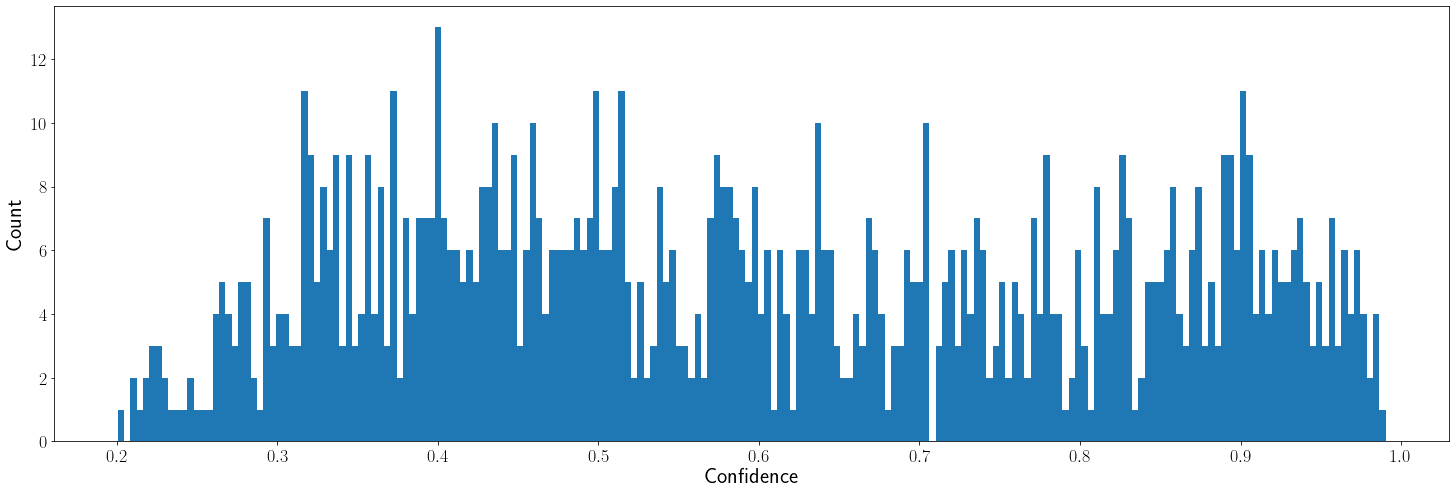

In [38]:
fig, ax = plt.subplots(figsize=(25, 8))

ax.hist(test_confs, bins=200)

ax.set_xlabel('Confidence', fontsize=22)
ax.set_ylabel('Count', fontsize=22)
ax.tick_params(axis='both', labelsize=18)

plt.show();

In [41]:
ix = np.argsort(test_confs)

q1, q2, q3, q4 = ix[:len(test_confs)//4], ix[len(test_confs)//4:len(test_confs)//2], ix[len(test_confs)//2: 3*len(test_confs)//4], ix[3*len(test_confs)//4:]


ts_aux = TempScaling()
ts_aux.fit(Z_test[q1], y_test[q1]);
T_q1 = ts_aux.T.detach().numpy()

ts_aux = TempScaling()
ts_aux.fit(Z_test[q2], y_test[q2]);
T_q2 = ts_aux.T.detach().numpy()

ts_aux = TempScaling()
ts_aux.fit(Z_test[q3], y_test[q3]);
T_q3 = ts_aux.T.detach().numpy()

ts_aux = TempScaling()
ts_aux.fit(Z_test[q4], y_test[q4]);
T_q4 = ts_aux.T.detach().numpy()



Ts = aTempScaler.get_T(Z_test)

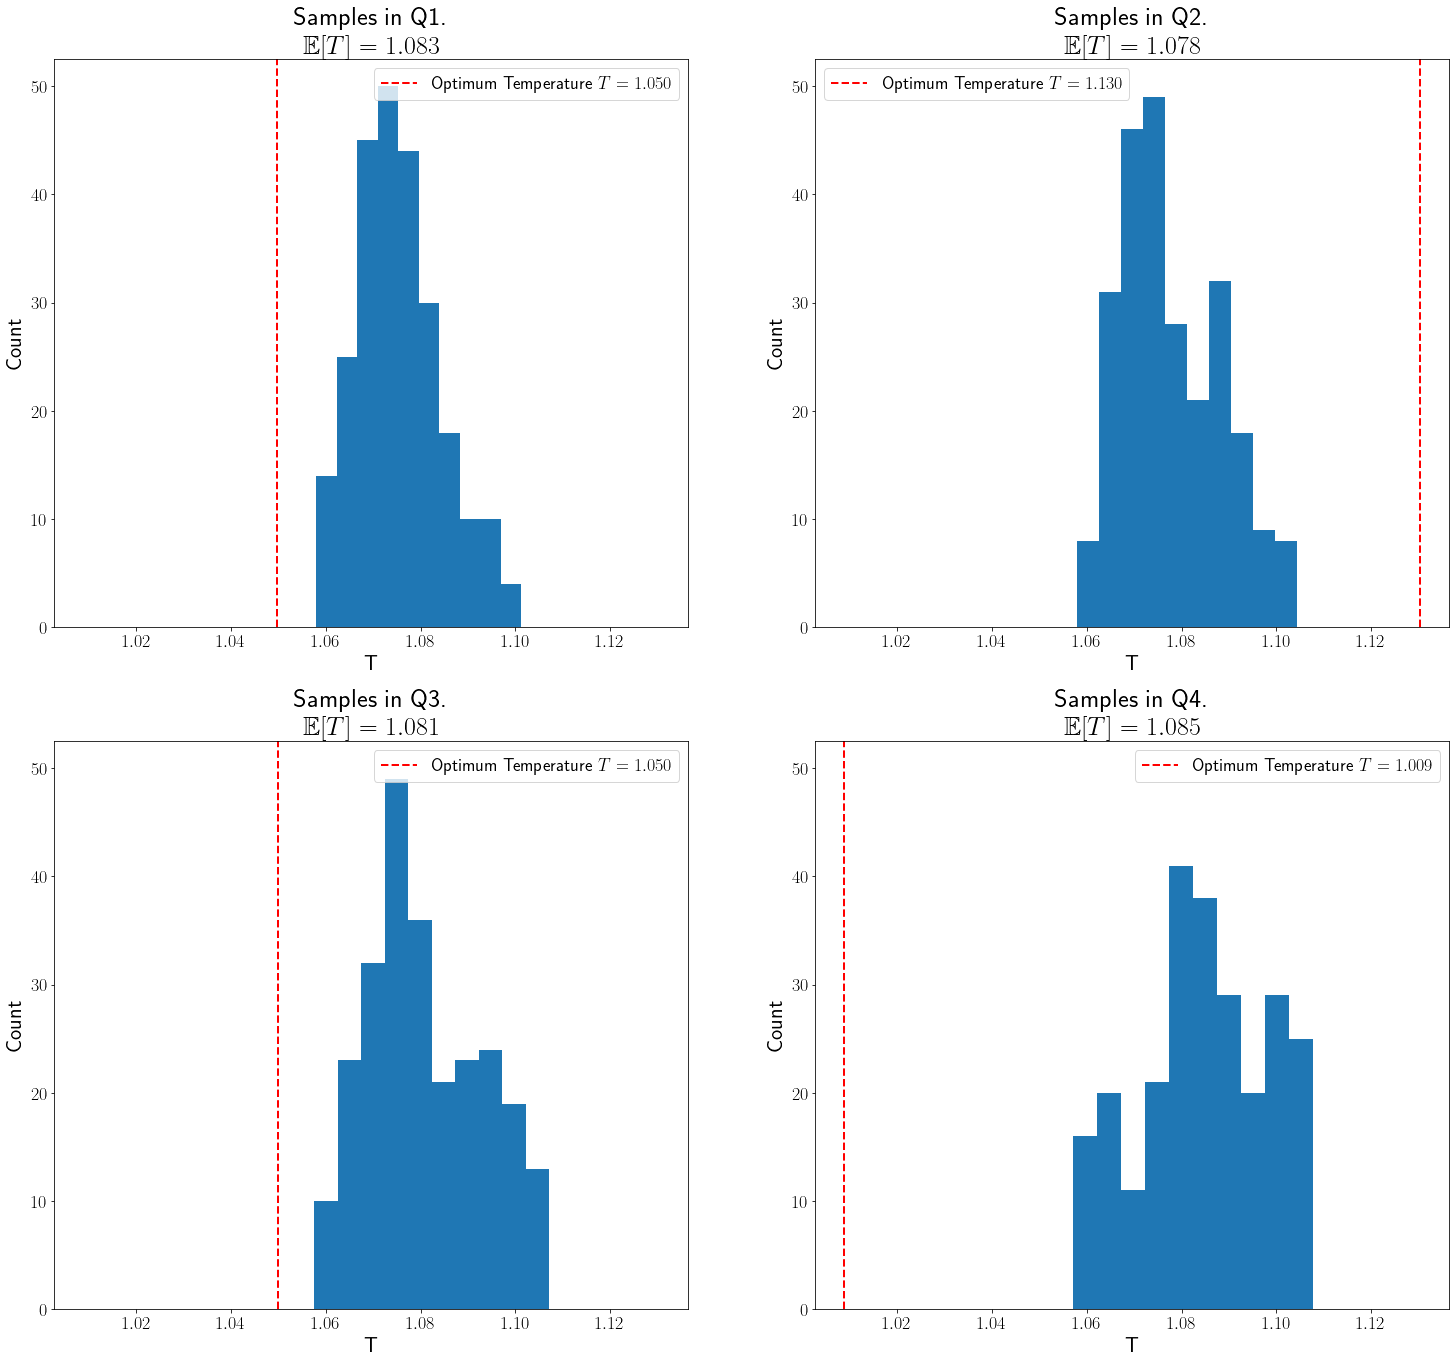

In [46]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(25, 23))


ax[0, 0].hist(Ts[q1])
ax[0, 0].axvline(T_q1, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q1[0]))
ax[0, 0].set_title('Samples in Q1.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[hc])), fontsize=26)


ax[0, 1].hist(Ts[q2])
ax[0, 1].axvline(T_q2, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q2[0]))
ax[0, 1].set_title('Samples in Q2.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[q2])), fontsize=26)


ax[1, 0].hist(Ts[q3])
ax[1, 0].axvline(T_q3, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q3[0]))
ax[1, 0].set_title('Samples in Q3.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[q3])), fontsize=26)


ax[1, 1].hist(Ts[q4])
ax[1, 1].axvline(T_q4, ls='--', lw=2, c='red', label='Optimum Temperature $T = {:.3f}$'.format(T_q4[0]))
ax[1, 1].set_title('Samples in Q4.\n $\mathbb{{E}}[T] = {:.3f}$'.format(np.mean(Ts[q4])), fontsize=26)

for _ax in ax.flatten():
    _ax.yaxis.set_tick_params(labelleft=True)
    _ax.xaxis.set_tick_params(labelbottom=True)
    _ax.legend(fontsize=18)
    _ax.set_xlabel('T', fontsize=22)
    _ax.set_ylabel('Count', fontsize=22)
    _ax.tick_params(axis='both', labelsize=18)

plt.show();